In [1]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, state_fidelity
from qiskit_experiments.library import StateTomography
from qclib.state_preparation import MixedInitialize, BaaLowRankInitialize
from qclib.state_preparation.util.baa import adaptive_approximation
from qclib.machine_learning.datasets import digits
from qclib.entanglement import schmidt_decomposition
from qclib.state_preparation.util.baa import _split_combinations
from qclib.util import get_cnot_count

# If you are not using the `qdna-lib` source code,
# comment out the following two lines.
import sys
sys.path.append('../../qdna-lib/')

from qdna.compression import SchmidtCompressor

***
## Configuration
***

In [2]:
shots = 1024 * 8
backend_type = 'local' # local, local_noisy, cloud, cloud_device
calc_type = 'tomography' # quasi-probs, tomography
classes = [0,1]
training_size = 160
test_size = 10
n_qubits = 6
low_rank = 0
max_fidelity_loss = 0.0
baa_strategy = 'brute_force'
use_low_rank = True

***
## Backend configuration
***

In [3]:
noise_model = None
coupling_map = None
basis_gates = None

if backend_type == 'cloud':
    # Cloud noiseless simulation
    from qiskit_ibm_provider import IBMProvider
    from qiskit.primitives import BackendSampler

    provider = IBMProvider(instance='ibm-q/open/main')
    backend  = provider.get_backend('ibmq_qasm_simulator')
    sampler = BackendSampler(
        backend=backend,
        options = {
            'shots' : shots
        }
    )

elif backend_type == 'cloud_device':
    # Cloud device
    from qiskit_ibm_provider import IBMProvider
    from qiskit.primitives import BackendSampler

    provider = IBMProvider(instance='ibm-q/open/main')
    backend  = provider.get_backend('ibm_osaka')
    sampler = BackendSampler(
        backend=backend,
        options = {
            'shots' : shots
        }
    )

elif backend_type == 'local_noisy':
    # Local noisy simulation
    from qiskit_aer import AerSimulator
    from qiskit.primitives import BackendSampler
    from qiskit.providers.fake_provider import FakeMumbai
    
    noisy_backend = FakeMumbai()
    
    backend = AerSimulator.from_backend(noisy_backend)
    sampler = BackendSampler(
        backend=backend,
        options = {
            'shots' : shots
        }
    )

else:
    # Local noiseless simulation
    from qiskit_aer import AerSimulator
    from qiskit.primitives import BackendSampler
    backend = AerSimulator(shots=shots)
    sampler = BackendSampler(
        backend=backend,
        options = {
            'shots' : shots
        }
    )

***
## Dataset
***

In [4]:
# Dataset load.
seed = 42

# Here you can choose the dataset classes. For example: [3], [0,1], [1,8], [2,4,7], etc.
sample_total, training_input, test_input, class_labels = digits.load(classes=classes,
                                                                     training_size=training_size,
                                                                     test_size=test_size,
                                                                     random_seed=seed,
                                                                     features=2**n_qubits)
feature_dim = len(training_input[class_labels[0]][0])
n_qubits = int(np.ceil(np.log2(feature_dim)))

# Variables to collect data for the summary.
fidelities = [[],[],[]]
figures = [[],[],[]]

In [5]:
# Prints information on training and test datasets.
for _, train_samples in training_input.items():
    print(train_samples.shape)
for _, test_samples in test_input.items():
    print(test_samples.shape)

(160, 64)
(160, 64)
(10, 64)
(10, 64)


***
## Experiment main routine
***

In [6]:
def calc_fidelity(state1, state2):
    bra = np.conj(state1)
    ket = state2

    return np.power(np.abs(bra.dot(ket)), 2)

def measurement(circuit, n_qubits, classical_register, backend, shots):
    """ run circuit and return measurements """
    circuit.measure(range(n_qubits), classical_register)

    result = sampler.run(circuit).result()

    counts = result.quasi_dists[0]

    counts2 = {}
    for k in range(2 ** n_qubits):
        if k in counts:
            counts2[k] = counts[k]
        else:
            counts2[k] = 0.0

    return np.array([value for (_, value) in counts2.items()])

def plot_digits(vectors, num_data_qubits, text=''):
    import matplotlib.pyplot as plt
    _dpi = 96
    matrix_dim_1 = 2**(int(np.ceil(num_data_qubits/2)))
    matrix_dim_2 = 2**(int(np.floor(num_data_qubits/2)))

    ncols = len(vectors)
    _, axes = plt.subplots(
        nrows=1,
        ncols=ncols,
        figsize=(
            ncols*10*matrix_dim_1/_dpi,
            10*matrix_dim_2/_dpi
        ),
        dpi=_dpi
    )
    for ax, vector in zip(axes, vectors):
        ax.set_axis_off()
        image = vector.reshape(matrix_dim_1, matrix_dim_2)
        ax.imshow(image, cmap=plt.cm.gray, interpolation='none')

    plt.show()

def calc_probabilities(circuit, test_sample):
    
    if calc_type == 'tomography':
        st = StateTomography(
            circuit,
            measurement_indices=range(n_qubits)
        )
        st_data = st.run(
            backend,
            basis_gates=basis_gates,
            coupling_map=coupling_map,
            shots=shots
        ).block_for_results()
        state = st_data.analysis_results("state").value
        rho = DensityMatrix(state)
        sigma = DensityMatrix(test_sample, dims=2**n_qubits)
        fidelity = state_fidelity(sigma.data, rho.data)
        output_probs = rho.probabilities(range(n_qubits))
    else:
        c_reg = ClassicalRegister(n_qubits)
        circuit.add_register(c_reg)
        output_probs = measurement(circuit, n_qubits, c_reg, backend, shots)
        fidelity = calc_fidelity(test_sample, np.sqrt(output_probs))

    return output_probs, fidelity

# Creates an example of the circuit.
def complete_circuit(initializer, compressor, decompressor, reference=None):

    # Info about the auxiliary space.
    len_aux = 0
    len_reference = 0
    if reference is not None:
        len_aux = reference[0].num_qubits // 2
        len_reference = len(reference)

    n_trash_qubits = len(compressor.trash_qubits)
    n_aux_qubits = len_aux * len_reference

    # Creates the quantum circuit.
    circuit = QuantumCircuit(n_qubits + n_trash_qubits + n_aux_qubits)

    latent_qubits = np.array(compressor.latent_qubits)
    trash_qubits = np.array(range(n_qubits, n_qubits+n_trash_qubits))
    aux_qubits = np.array(range(n_qubits+n_trash_qubits, n_qubits + n_trash_qubits + n_aux_qubits))

    # Circuit on Alice's side.
    alice_register = np.array([None] * compressor.num_qubits)
    alice_register[compressor.trash_qubits] = trash_qubits[:]
    alice_register[compressor.latent_qubits] = latent_qubits[:]
    
    circuit.append(initializer.definition, [*alice_register])
    circuit.append(compressor.definition, [*alice_register])

    # Circuit on Bob's side.
    bob_register = list(range(n_qubits))

    if reference is not None:
        circuit.barrier()
        bob_trash_qubits = np.array(decompressor.trash_qubits)
        for i, ref_initializer in enumerate(reference):
            qubits_idx = list(range(i * len_aux, (i+1) * len_aux))
            circuit.compose(
                ref_initializer.definition,
                [*aux_qubits[qubits_idx], *bob_trash_qubits[qubits_idx]],
                inplace=True
            )
        circuit.barrier()
    circuit.append(decompressor.definition, bob_register)

    return circuit  

def experiment(test_input, compressor, decompressor, references=None, verbose=1):
    # Applies the compression-decompression process to each of the test samples.

    fidelities = []
    figures = []

    # Iterates through all test samples.
    for i, test_sample in enumerate(np.concatenate([test_samples for _, test_samples in test_input.items()])):
        reference = None
        if references is not None:
            reference = references[i]

        # initializer = StatePreparation(test_sample)
        initializer = BaaLowRankInitialize(
            test_sample,
            opt_params={
                'max_fidelity_loss': max_fidelity_loss,
                'strategy': baa_strategy,
                'use_low_rank': use_low_rank
            }
        )
        circuit = complete_circuit(initializer, compressor, decompressor, reference=reference)

        output_probs, fidelity = calc_probabilities(circuit, test_sample)
        
        # Calculates the approximate state vector
        node = adaptive_approximation(
            test_sample,
            max_fidelity_loss=max_fidelity_loss,
            strategy=baa_strategy,
            use_low_rank=use_low_rank
        )

        # Stores and prints the results.
        fidelities.append(fidelity)
        figures.append([np.abs(test_sample)**2, np.abs(node.state_vector())**2, output_probs])
        if verbose > 0:
            print(i, '- Recovered state fidelity =', fidelity)
        if verbose > 1:
            plot_digits([np.abs(test_sample)**2, np.abs(node.state_vector())**2, output_probs], n_qubits)

    return fidelities, figures

***
## Calculates the typical state
***

In [7]:
# Estimate the centroid.
# Simply the average of the training samples (or a random selection of samples).

centroid = np.zeros(2**n_qubits)
for train_sample in np.concatenate([train_samples for _, train_samples in training_input.items()]):
    # Calculates the approximate state vector
    node = adaptive_approximation(
        train_sample,
        max_fidelity_loss=max_fidelity_loss,
        strategy=baa_strategy,
        use_low_rank=use_low_rank
    )
    centroid += node.state_vector()

typical_state = centroid / np.linalg.norm(centroid)

print(typical_state.shape)

(64,)


In [8]:
np.linalg.norm(typical_state)

1.0

***
## Find the best partitioning configuration.
***

In [9]:
# Defines the number of latent qubits.
# `0 < n_latent_qubits < n_qubits`.
n_latent_qubits = n_qubits // 2

n_trash_qubits = n_qubits - n_latent_qubits

def von_neumann_entropy(singular_values):
    squared_singular_values = np.power([s for s in singular_values if s >= 1e-17], 2)
    return -np.sum(squared_singular_values * np.log(squared_singular_values))

# Set `min_entropy` equal to the maximum entropy for the system.
min_entropy = von_neumann_entropy(
    [1/np.sqrt(2**n_latent_qubits)] * 2**n_latent_qubits
)

for trash_qubits in _split_combinations(range(n_qubits), n_trash_qubits):
    rank, svd_u, singular_values, svd_v = schmidt_decomposition(
        typical_state, trash_qubits, rank=0, svd='auto'
    )
    
    entropy = von_neumann_entropy(singular_values)

    print('trash_qubits', trash_qubits, 'entropy', entropy)
    if entropy <= min_entropy:
        min_entropy = entropy
        latent_qubits = sorted(set(range(n_qubits)).difference(set(trash_qubits)))

trash_qubits (0, 1, 2) entropy 0.2671940046300695
trash_qubits (0, 1, 3) entropy 0.9286829198048681
trash_qubits (0, 1, 4) entropy 0.9405683918342369
trash_qubits (0, 1, 5) entropy 0.4312852752224746
trash_qubits (0, 2, 3) entropy 0.9722818204677055
trash_qubits (0, 2, 4) entropy 0.9615693411987976
trash_qubits (0, 2, 5) entropy 0.43194813154194395
trash_qubits (0, 3, 4) entropy 0.3896715799342443
trash_qubits (0, 3, 5) entropy 0.9311020598127034
trash_qubits (0, 4, 5) entropy 0.948098211267135


In [10]:
print('Best channel:', latent_qubits)

Best channel: [3, 4, 5]


***
## Creates the compressor and the decompressor
***

In [11]:
# Creates the compressor.

# These are the qubits of the quantum channel for data transmission.
# It can take on any configuration. For example: [0], [0,1,2,3,4], [1,3,5], etc.
# latent_qubits = [3,4,5]

compressor = SchmidtCompressor(
    typical_state,
    opt_params={'partition': latent_qubits, 'lr': low_rank}
)
decompressor = compressor.inverse()

In [12]:
print(get_cnot_count(compressor.definition))

43


***
## Experiment without optimization
***
Using |0> as the reference state.


### Draw an example of the circuit


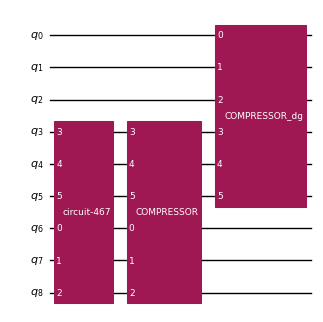

In [13]:
circuit = complete_circuit(
    BaaLowRankInitialize(
        typical_state,
        opt_params={
            'max_fidelity_loss': max_fidelity_loss,
            'strategy': baa_strategy,
            'use_low_rank': use_low_rank
        }
    ),
    compressor,
    decompressor
)
# Draw the circuit diagram.
circuit.draw('mpl', scale=0.5, style="iqp")

In [14]:
print(get_cnot_count(circuit))

133


### Run the experiment without optimization

0 - Recovered state fidelity = 0.8675603636595267


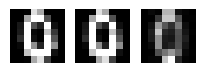

1 - Recovered state fidelity = 0.6750814343613838


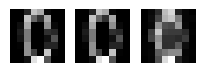

2 - Recovered state fidelity = 0.8541329493127416


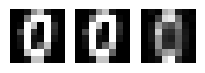

3 - Recovered state fidelity = 0.7724655814808706


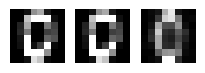

4 - Recovered state fidelity = 0.6179585272092195


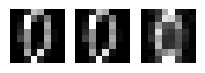

5 - Recovered state fidelity = 0.7586469290003383


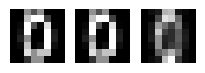

6 - Recovered state fidelity = 0.7961715588687016


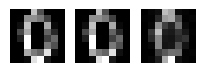

7 - Recovered state fidelity = 0.6416531922131602


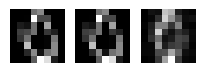

8 - Recovered state fidelity = 0.6555940024261881


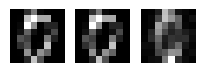

9 - Recovered state fidelity = 0.66569624707277


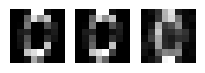

10 - Recovered state fidelity = 0.5889098367625941


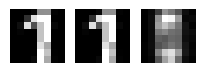

11 - Recovered state fidelity = 0.5760108045210722


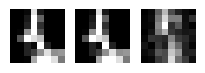

12 - Recovered state fidelity = 0.41641384402107906


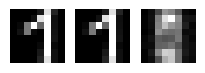

13 - Recovered state fidelity = 0.6189516170432499


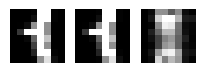

14 - Recovered state fidelity = 0.6587816675034431


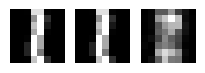

15 - Recovered state fidelity = 0.5375236094267828


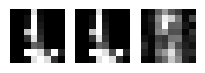

16 - Recovered state fidelity = 0.46037254994149424


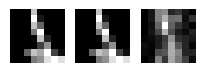

17 - Recovered state fidelity = 0.7205807330135221


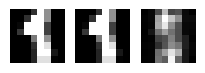

18 - Recovered state fidelity = 0.7707479103729646


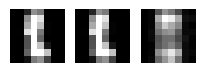

19 - Recovered state fidelity = 0.5334803259028755


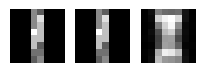

In [15]:
fidelities[0], figures[0] = experiment(
    test_input,
    compressor,
    decompressor,
    verbose=2
)

***
## Experiment with optimization 1
***
This optimization is based on the conservation of entropy.
As we are dealing with a pure state (Alice's side), our goal is to produce an initial state of zero entropy (or close to zero) on Bob's side.

### Constructs the set of gates to initialize the mixed-states.

In [16]:
# Applies the compression process to each of the train samples,
# calculates the correspondent trash state,
# and stores the correspondent mixed state initializer gate.

references_1 = []
for i, test_sample in enumerate(np.concatenate([test_samples for _, test_samples in test_input.items()])):
    initializer = BaaLowRankInitialize(
        test_sample,
        opt_params={
            'max_fidelity_loss': max_fidelity_loss,
            'strategy': baa_strategy,
            'use_low_rank': use_low_rank
        }
    )

    circuit = QuantumCircuit(n_qubits)
    circuit.append(initializer.definition, range(n_qubits))
    circuit.append(compressor.definition, range(n_qubits))

    trash_state = partial_trace(Statevector(circuit), compressor.latent_qubits)
    references_1.append([
        MixedInitialize(
            trash_state.data.T,
            classical=True,
            reset=False,
            initializer=BaaLowRankInitialize,
            opt_params={
                'max_fidelity_loss': max_fidelity_loss,
                'strategy': baa_strategy,
                'use_low_rank': use_low_rank
            }
        )
    ])

### Draw an example of the reference state initializer

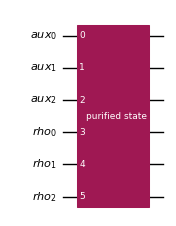

In [17]:
references_1[0][0].definition.draw('mpl', scale=0.5, style="iqp")

### Draws an example of the complete circuit

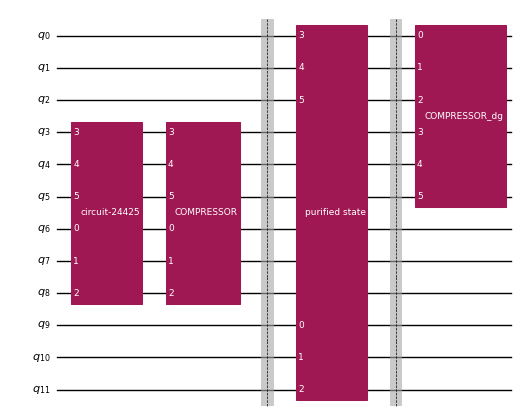

In [18]:
circuit = complete_circuit(
    BaaLowRankInitialize(
        typical_state,
        opt_params={
            'max_fidelity_loss': max_fidelity_loss,
            'strategy': baa_strategy,
            'use_low_rank': use_low_rank
        }
    ),
    compressor,
    decompressor,
    references_1[0]
)
# Draw an example of the circuit.
circuit.draw('mpl', scale=0.5, style="iqp")

In [19]:
print(get_cnot_count(circuit))

178


## Optimized experiment:
Uses the exact trash state as the reference state.
This relies on classical communication, as the trash state must be transmited between Alice and Bob for each execution.

In [20]:
fidelities[1], figures[1] = experiment(
    test_input,
    compressor,
    decompressor,
    references=references_1,
    verbose=1
)

0 - Recovered state fidelity = 0.8927392483531622
1 - Recovered state fidelity = 0.6917549522647357
2 - Recovered state fidelity = 0.8737518455806903
3 - Recovered state fidelity = 0.7901746805985294
4 - Recovered state fidelity = 0.6797472494683613
5 - Recovered state fidelity = 0.8145828194956741
6 - Recovered state fidelity = 0.8303605766929563
7 - Recovered state fidelity = 0.6714614796410787
8 - Recovered state fidelity = 0.6989831998624132
9 - Recovered state fidelity = 0.662379130449898
10 - Recovered state fidelity = 0.7899431873919811
11 - Recovered state fidelity = 0.6032230023374329
12 - Recovered state fidelity = 0.6738939075880326
13 - Recovered state fidelity = 0.7742404157015292
14 - Recovered state fidelity = 0.89209695103553
15 - Recovered state fidelity = 0.6227662789119451
16 - Recovered state fidelity = 0.49895853684638636
17 - Recovered state fidelity = 0.7685983350237209
18 - Recovered state fidelity = 0.8629746521763528
19 - Recovered state fidelity = 0.924955487

***
## Experiment with optimization 2
***
This optimization reduces the cost of the previous one by relying on single-qubit tomography. That way, the cost of the tomography is linear on the number of trash qubits, O(n_t), and the cost of the classical communication is also O(n_t).

### Constructs the set of gates to initialize the mixed-states.

In [21]:
references_2 = []

for i, test_sample in enumerate(np.concatenate([test_samples for _, test_samples in test_input.items()])):
    initializer = BaaLowRankInitialize(
        test_sample,
        opt_params={
            'max_fidelity_loss': max_fidelity_loss,
            'strategy': baa_strategy,
            'use_low_rank': use_low_rank
        }
    )

    circuit = QuantumCircuit(n_qubits)
    circuit.append(initializer.definition, range(n_qubits))
    circuit.append(compressor.definition, range(n_qubits))

    single_qubit_initializers = []
    for trash_qubit in compressor.trash_qubits:
        trash_qubits = list(set(compressor.trash_qubits) - set([trash_qubit]))
        trash_state = partial_trace(Statevector(circuit), trash_qubits + compressor.latent_qubits)
        single_qubit_initializers.append(
            MixedInitialize(
                trash_state.data.T,
                classical=True,
                reset=False
            )
        )

    references_2.append(single_qubit_initializers)

### Draw an example of the reference state initializer

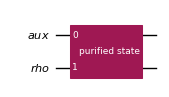

In [22]:
references_2[0][0].definition.draw('mpl', scale=0.5, style="iqp")

### Draw an example of the complete circuit

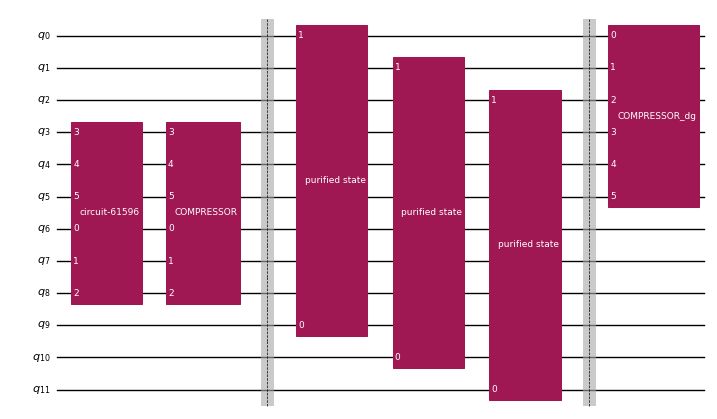

In [23]:
circuit = complete_circuit(
    BaaLowRankInitialize(
        typical_state,
        opt_params={
            'max_fidelity_loss': max_fidelity_loss,
            'strategy': baa_strategy,
            'use_low_rank': use_low_rank
        }
    ),
    compressor,
    decompressor,
    references_2[0]
)
# Draw an example of the circuit.
circuit.draw('mpl', scale=0.5, style="iqp")

In [24]:
print(get_cnot_count(circuit))

136


## Optimized experiment:
Uses the single-qubit trash states as the reference state.
This relies on classical communication, as the trash state must be transmited between Alice and Bob for each execution, but the cost is only O(n_t).

In [25]:
fidelities[2], figures[2] = experiment(
    test_input,
    compressor,
    decompressor,
    references=references_2,
    verbose=1
)

0 - Recovered state fidelity = 0.8863101872104165
1 - Recovered state fidelity = 0.6865288750913623
2 - Recovered state fidelity = 0.8691256941991231
3 - Recovered state fidelity = 0.7840581023229367
4 - Recovered state fidelity = 0.65508040969423
5 - Recovered state fidelity = 0.8018233407271513
6 - Recovered state fidelity = 0.8255985905880241
7 - Recovered state fidelity = 0.6428739455384754
8 - Recovered state fidelity = 0.6664703859196667
9 - Recovered state fidelity = 0.6499336187942336
10 - Recovered state fidelity = 0.5615280389734407
11 - Recovered state fidelity = 0.5516049096973018
12 - Recovered state fidelity = 0.468265109583054
13 - Recovered state fidelity = 0.6297726688263772
14 - Recovered state fidelity = 0.8710156062485823
15 - Recovered state fidelity = 0.504465790680518
16 - Recovered state fidelity = 0.42377657495681326
17 - Recovered state fidelity = 0.7313465862635634
18 - Recovered state fidelity = 0.818046583343552
19 - Recovered state fidelity = 0.87623654148

***
## Summary
***

In [26]:
zip_fidelities = list(zip(fidelities[0],fidelities[1],fidelities[2]))
for i, (item1, item2, item3) in enumerate(zip_fidelities):
    print(i, '-', item1, item2, item3)

print('\navg', *np.average(zip_fidelities, axis=0))
print('min', *np.min(zip_fidelities, axis=0))
print('max', *np.max(zip_fidelities, axis=0))
print('std', *np.std(zip_fidelities, axis=0))

0 - 0.8675603636595267 0.8927392483531622 0.8863101872104165
1 - 0.6750814343613838 0.6917549522647357 0.6865288750913623
2 - 0.8541329493127416 0.8737518455806903 0.8691256941991231
3 - 0.7724655814808706 0.7901746805985294 0.7840581023229367
4 - 0.6179585272092195 0.6797472494683613 0.65508040969423
5 - 0.7586469290003383 0.8145828194956741 0.8018233407271513
6 - 0.7961715588687016 0.8303605766929563 0.8255985905880241
7 - 0.6416531922131602 0.6714614796410787 0.6428739455384754
8 - 0.6555940024261881 0.6989831998624132 0.6664703859196667
9 - 0.66569624707277 0.662379130449898 0.6499336187942336
10 - 0.5889098367625941 0.7899431873919811 0.5615280389734407
11 - 0.5760108045210722 0.6032230023374329 0.5516049096973018
12 - 0.41641384402107906 0.6738939075880326 0.468265109583054
13 - 0.6189516170432499 0.7742404157015292 0.6297726688263772
14 - 0.6587816675034431 0.89209695103553 0.8710156062485823
15 - 0.5375236094267828 0.6227662789119451 0.504465790680518
16 - 0.46037254994149424 0

0


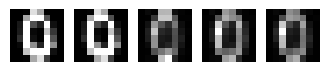

1


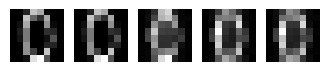

2


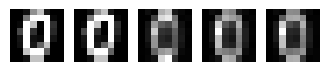

3


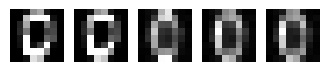

4


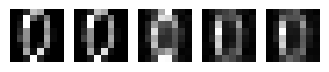

5


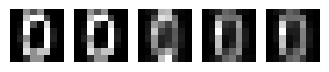

6


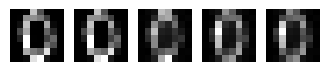

7


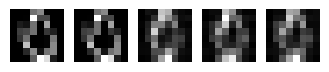

8


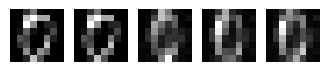

9


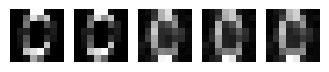

10


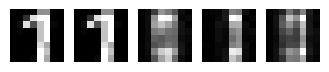

11


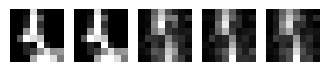

12


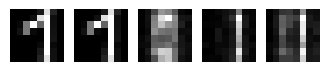

13


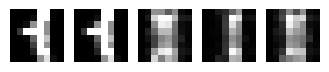

14


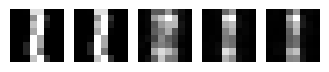

15


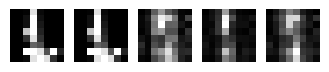

16


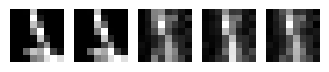

17


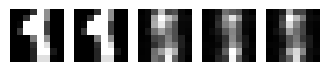

18


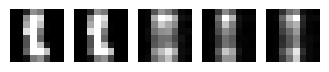

19


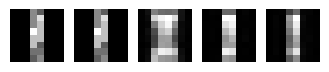

In [27]:
for i, (item1, item2, item3) in enumerate(zip(figures[0],figures[1],figures[2])):
    print(i)
    plot_digits([item1[0], item1[1], item1[2], item2[2], item3[2]], n_qubits)